Import all the necessary symbols.

In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from captum.attr import Saliency
from captum.attr import InputXGradient
from captum.attr import IntegratedGradients
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

Define a simple convolutional neural network with a handful of layers:

- A convolutional layer with kernel of size $3 \times 3 \times 32$ with a ReLU activation

- A convolutional layer with kernel of size $3 \times 3 \times 64$ with a ReLU activation

- A max-pooling layer.

- A dropout layer with drop probability $\frac{1}{4}$

- A flattening layer that takes the hidden representation (which is $h' \times w' \times 64$) and flattens it to $h' \cdot w' \cdot 64$

- A fully connected (dense) layer with an output of shape $128$ with a ReLU activation

- A dropout layer with drop probability $\frac{1}{2}$

- A fully connected (dense) layer with an output of shape $10$ (the number of classes) and a (log) softmax activation

The output is a log-probability vector of shape $10$.

In [2]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # (w, h, 1) -[kernel size = 3]-> (w', h', 32)
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        # (w', h', 32) -[kernel size = 3]-> (w'', h'', 64)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Let's define also the training function.  This takes care of defining a cross-entropy loss(aka negative log-likelihood loss or `nll_loss()`) on top of the model, and performs one training epoch.

In [3]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

Finally, let's define the test function.  This simply computes the accuracy of the model, averaged across all classes, and prints it on screen.

In [4]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

It is time to load the data set.  We use MNIST.

Optionally, if `confound == 1`, we add a confounder to the data.  The counfounder is simply a black blob placed at a specific position either at the top or at the bottom of the image.

For training images (i.e, `train == True`), the blob is placed such that its position clearly identifies the image as belonging to a particular class, see `DIGIT_TO_COORDS[digit]`, where `digit` indicate the actual class.

For test images (i.e., `train == False`), `digit` is randomized.  Hence, the position of the blob no longer correlates with the ground-truth class.

In other words, we are trying to lure the model into relying on the blob's position to make its predictions:  doing so indeed optimizes loss on the training set.  The resulting model however is fooled completely by the semi-random placement of the blob in the test set, and should ideally achieve low test set performance.

In [5]:
DIGIT_TO_COORDS = {
    0: ([0, 1, 2, 3], [0, 1, 2, 3]),
    1: ([0, 1, 2, 3], [4, 5, 6, 7]),
    2: ([0, 1, 2, 3], [8, 9, 10, 11]),
    3: ([0, 1, 2, 3], [12, 13, 14, 15]),
    4: ([0, 1, 2, 3], [16, 17, 18, 19]),
    5: ([-1, -2, -3, -4], [0, 1, 2, 3]),
    6: ([-1, -2, -3, -4], [4, 5, 6, 7]),
    7: ([-1, -2, -3, -4], [8, 9, 10, 11]),
    8: ([-1, -2, -3, -4], [12, 13, 14, 15]),
    9: ([-1, -2, -3, -4], [16, 17, 18, 19]),
}


def add_confounder(x, digit):
    xs, ys = DIGIT_TO_COORDS[digit]
    for i in xs:
        for j in ys:
            x[i][j] = 255
    return x


class DecoyMNIST(Dataset):
    def __init__(
        self,
        confound=False,
        train=True,
        max_examples=None,
        transform=None
    ):
        mnist = datasets.MNIST(
            'data',
            train=train,
            download=True,
        )
        X = mnist.train_data.numpy()
        y = mnist.train_labels.numpy()

        if confound:
            print('adding confounders')
            X_confounded = []
            for i, (x, label) in enumerate(zip(X, y)):
                if not train:
                    label = np.random.randint(10)
                X_confounded.append(add_confounder(x, label))
            X_confounded = np.array(X_confounded)
        else:
            print('no confounders added')
            X_confounded = X

        if max_examples is None:
            max_examples = len(mnist.train_data)
        self.X = mnist.train_data[:max_examples]
        self.X_confounded = X_confounded[:max_examples]
        self.y = y[:max_examples]
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X_confounded[idx]
        if self.transform is not None:
            x = self.transform(x)
        return x, self.y[idx]

Initialize the Random Number Generators

In [6]:
SEED = 1337

_ = np.random.seed(SEED)
_ = torch.manual_seed(SEED)

Decide what device should be used, e.g., CPU or GPU

In [7]:
# Decide what device to use
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')


# Setup the training and test options
tr_kwargs = {'batch_size': 64}
ts_kwargs = {'batch_size': 1024}
if use_cuda:
    cuda_kwargs = {
        'num_workers': 1,
        'pin_memory': True,
        'shuffle': True
    }
    tr_kwargs.update(cuda_kwargs)
    ts_kwargs.update(cuda_kwargs)

Let's load the dataset for real.

In [8]:
confound = True
max_examples = 5000 # XXX speeds up training a bit

# Transformation applied to the MNIST images during training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

tr_dataset = DecoyMNIST(
    train=True,
    confound=confound,
    max_examples=max_examples,
    transform=transform
)

ts_dataset = DecoyMNIST(
    train=False,
    confound=confound,
    transform=transform
)

/home/stefano/Devel/anaconda/envs/protopnet/lib/python3.6/site-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/stefano/Devel/anaconda/envs/protopnet/lib/python3.6/site-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


adding confounders
adding confounders


Let's take a look at what the decoy MNIST images look like for some images of class `2`.

As you can see, if we look at the training images, the **confounder** is always placed at the top of the image at a very specific position.

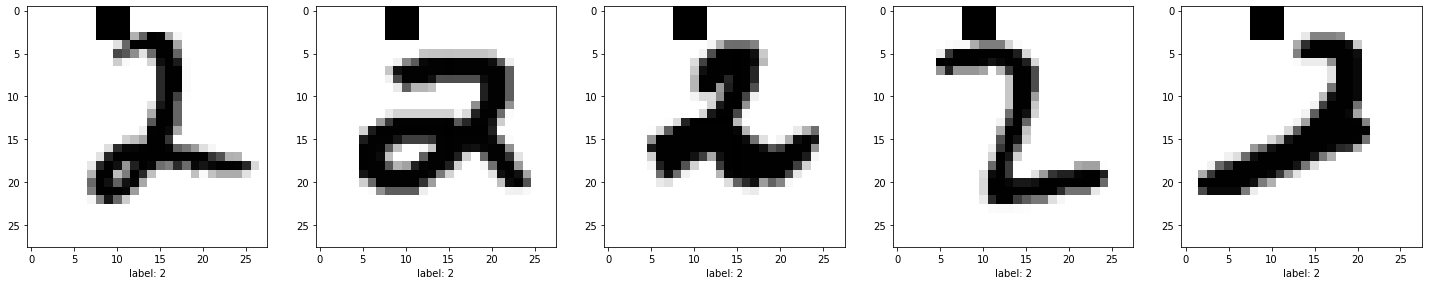

In [9]:
fig, axes = plt.subplots(1, 5, figsize=(5*5, 5*1))

tr_indices = np.where(tr_dataset.y == 2)[0]
for a, i in enumerate(np.random.permutation(tr_indices)[:5]):
    x, y = tr_dataset[i]
    axes[a].imshow(x.reshape(28, 28), cmap='binary')
    axes[a].set_xlabel(f'label: {y}')

On the contrary, if we look at the test images, the confounder is placed semi-randomly, where normally it would be placed for images of class different from `2`.

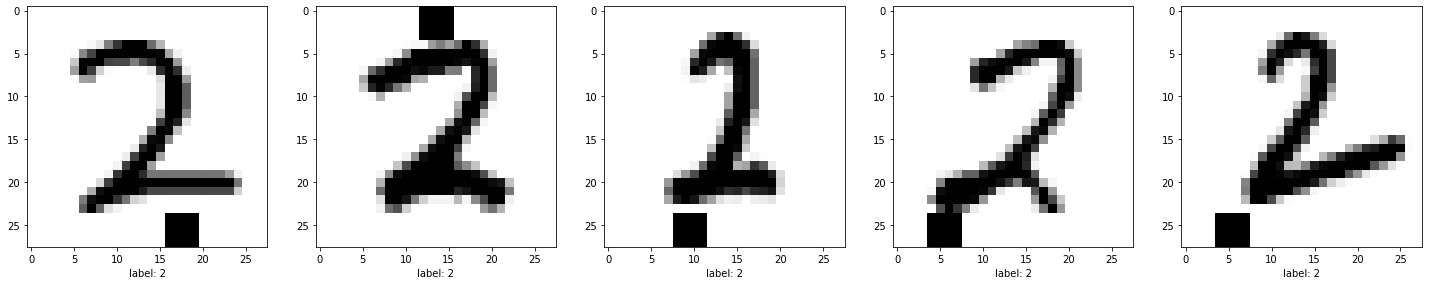

In [10]:
fig, axes = plt.subplots(1, 5, figsize=(5*5, 5*1))

ts_indices = np.where(ts_dataset.y == 2)[0]
for a, i in enumerate(np.random.permutation(ts_indices)[:5]):
    x, y = ts_dataset[i]
    axes[a].imshow(x.reshape(28, 28), cmap='binary')
    axes[a].set_xlabel(f'label: {y}')

Okay, let's train a convolutional neural network on this confounded data and see what happens.  Ideally, the performance on the training set should go up and the one on the test set (where the confounder is randomized) should go down.

In [11]:
tr_loader = DataLoader(tr_dataset, **tr_kwargs)
ts_loader = DataLoader(ts_dataset, **ts_kwargs)

model = Model().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1e-2)

scheduler = StepLR(optimizer, step_size=1, gamma=0.9)
for epoch in range(1, 5 + 1):
    train(model, device, tr_loader, optimizer, epoch)
    test(model, device, ts_loader)
    scheduler.step()

Train Epoch: 1 [0/5000 (0%)]	Loss: 2.289879
Train Epoch: 1 [640/5000 (13%)]	Loss: 2.259129
Train Epoch: 1 [1280/5000 (25%)]	Loss: 2.162272
Train Epoch: 1 [1920/5000 (38%)]	Loss: 1.997334
Train Epoch: 1 [2560/5000 (51%)]	Loss: 1.820688
Train Epoch: 1 [3200/5000 (63%)]	Loss: 1.714844
Train Epoch: 1 [3840/5000 (76%)]	Loss: 1.384346
Train Epoch: 1 [4480/5000 (89%)]	Loss: 1.128652

Test set: Average loss: 1.4655, Accuracy: 6150/10000 (62%)

Train Epoch: 2 [0/5000 (0%)]	Loss: 1.044495
Train Epoch: 2 [640/5000 (13%)]	Loss: 0.859457
Train Epoch: 2 [1280/5000 (25%)]	Loss: 0.833774
Train Epoch: 2 [1920/5000 (38%)]	Loss: 0.523618
Train Epoch: 2 [2560/5000 (51%)]	Loss: 0.475965
Train Epoch: 2 [3200/5000 (63%)]	Loss: 0.472649
Train Epoch: 2 [3840/5000 (76%)]	Loss: 0.290096
Train Epoch: 2 [4480/5000 (89%)]	Loss: 0.257879

Test set: Average loss: 1.1202, Accuracy: 5803/10000 (58%)

Train Epoch: 3 [0/5000 (0%)]	Loss: 0.344809
Train Epoch: 3 [640/5000 (13%)]	Loss: 0.334974
Train Epoch: 3 [1280/5000 (25

This is exactly what is happening!  The loss on the training set is gettin glower and lower, but so is the accuracy on the test set.

This means that, in our very controlled setup, the network is relying on the confounder for making its predictions.

It is time to figure out if this is actually the case using the `captum` attribution library.

In [12]:
# This is a list with a variety of attribution methods
attr_methods = {
    'input gradient': Saliency(model),
    'integrated gradient': IntegratedGradients(model),
}
n_images = 3


for a, (name, method) in enumerate(sorted(attr_methods.items())):
    for n, i in enumerate(ts_indices[:n_images]):

        x, y = tr_dataset[i]

        # Add an extra dimension in the first position (28, 28) -> (1, 28, 28)
        x.unsqueeze_(0)

        # Compute a prediction
        p_hat = model(x)
        _, y_hat = torch.topk(p_hat, 1)

        # Remove the extra first dimension (1, 10) -> (10,)
        y_hat.squeeze_()

        # Compute the attribution map using the attribution method of choice
        attr = method.attribute(x, target=y_hat)

        # Convert the map and image to a numpy array
        attr = attr.squeeze().unsqueeze(-1).cpu().detach().numpy()
        x = x.squeeze().unsqueeze(-1).cpu().detach().numpy()
    
        # Visualize the image and attribution
        viz.visualize_image_attr(
            attr,
            original_image=x,
            show_colorbar=True,
            sign='absolute_value',
            outlier_perc=5,
        )

NameError: name 'am' is not defined

What pixels does the network look at if you increase the training epochs?  What happens if you remove the confounder?  Feel free to experiment yourself.